# Decision tree in depth

In this notebook, we will go into details on the internal algorithm used to
build the decision tree. First, we will focus on the decision tree used for
classification. Then, we will highlight the fundamental difference between
decision tree used in classification and in regression. Finally, we will
quickly discuss the importance of the hyperparameters to be aware of when
using decision trees.

## Presentation of the dataset

We use the
[Palmer penguins dataset](https://allisonhorst.github.io/palmerpenguins/).
This dataset is composed of penguins records and ultimately, we want to
identify from which specie a penguin belongs to.

A penguin is from one of the three following species: Adelie, Gentoo, and
Chinstrap. See the illustration below depicting of the three different bird
species:

![Image of penguins](https://github.com/allisonhorst/palmerpenguins/raw/master/man/figures/lter_penguins.png)

This problem is a classification problem since the target is made of
categories. We will limit our input data to a subset of the original features
to simplify our explanations when presenting the decision tree algorithm.
Indeed, we will use feature based on penguins' culmen measurement. You can
learn more about the penguins' culmen with illustration below:

![Image of culmen](https://github.com/allisonhorst/palmerpenguins/raw/master/man/figures/culmen_depth.png)

In [1]:
import pandas as pd

data = pd.read_csv("../datasets/penguins.csv")

# select the features of interest
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

data = data[culmen_columns + [target_column]]
data[target_column] = data[target_column].str.split().str[0]

Let's check the dataset more into details.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Culmen Length (mm)  342 non-null    float64
 1   Culmen Depth (mm)   342 non-null    float64
 2   Species             344 non-null    object 
dtypes: float64(2), object(1)
memory usage: 8.2+ KB


We can observe that they are 2 missing records in this dataset and for the
sake of simplicity, we will drop the records corresponding to these 2
samples.

In [3]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Culmen Length (mm)  342 non-null    float64
 1   Culmen Depth (mm)   342 non-null    float64
 2   Species             342 non-null    object 
dtypes: float64(2), object(1)
memory usage: 10.7+ KB


We will separate the target from the data and we will create a training and a
testing set.

In [4]:
from sklearn.model_selection import train_test_split

X, y = data[culmen_columns], data[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0,
)

Before going into details in the decision tree algorithm, we will quickly
inspect our dataset.

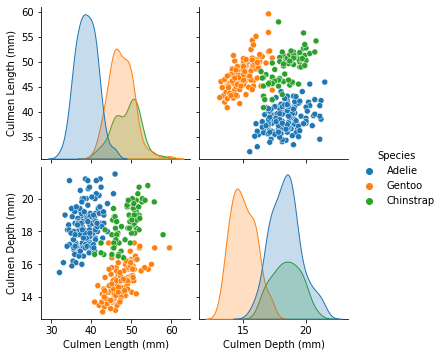

In [5]:
import seaborn as sns

_ = sns.pairplot(data=data, hue="Species")

We can first check the feature distributions by looking at the diagonal plots
of the pairplot. We can build the following intuitions:

* The Adelie specie is separable from the Gentoo and Chinstrap species using
  the culmen length;
* The Gentoo specie is separable from the Adelie and Chinstrap species using
  the culmen depth.

## How decision tree are built?

In a previous notebook, we learnt that a linear classifier will define a
linear separation to split classes using a linear combination of the input
features. In our 2-dimensional space, it means that a linear classifier will
defined some oblique lines that best separate our classes. We define a
function below that given a set of data point and a classifier will plot the
decision boundaries learnt by the classifier.

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def plot_decision_function(X, y, clf, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    clf.fit(X, y)

    # create a grid to evaluate all possible samples
    plot_step = 0.02
    feature_0_min, feature_0_max = (X.iloc[:, 0].min() - 1,
                                    X.iloc[:, 0].max() + 1)
    feature_1_min, feature_1_max = (X.iloc[:, 1].min() - 1,
                                    X.iloc[:, 1].max() + 1)
    xx, yy = np.meshgrid(
        np.arange(feature_0_min, feature_0_max, plot_step),
        np.arange(feature_1_min, feature_1_max, plot_step)
    )

    # compute the associated prediction
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4)
    sns.scatterplot(
        data=pd.concat([X, y], axis=1),
        x=X.columns[0], y=X.columns[1], hue=y.name,
        ax=ax,
    )

Thus, for a linear classifier, we will obtain the following decision
boundaries.

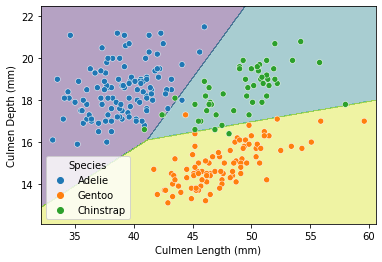

In [7]:
from sklearn.linear_model import LogisticRegression

linear_model = LogisticRegression()
plot_decision_function(X_train, y_train, linear_model)

We see that the lines are a combination of the input features since they are
not perpendicular a specific axis. In addition, it seems that the linear
model would be a good candidate model for such problem, giving a good
accuracy.

In [8]:
print(
    f"Accuracy of the {linear_model.__class__.__name__}: "
    f"{linear_model.fit(X_train, y_train).score(X_test, y_test):.2f}"
)

Accuracy of the LogisticRegression: 0.97


Unlike linear model, decision tree will partition the space considering a
single feature at a time. Let's illustrate this behaviour by having
a decision tree which makes a single split to partition the feature space.
the decision tree to make a single split to partition our feature space.

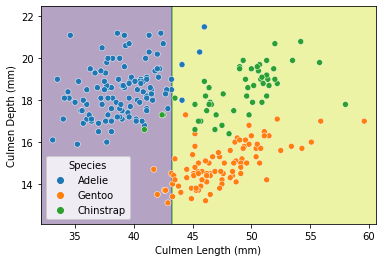

In [9]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=1)
plot_decision_function(X_train, y_train, tree)

The partition found separate the data along the axis "Culmen Length",
discarding the feature "Culmen Depth". Thus, it highlights that a decision
tree does not use a combination of feature when making a split.

However, such a split is not powerful enough to isolate the three species and
the model accuracy is low compared to the linear model.

In [10]:
print(
    f"Accuracy of the {tree.__class__.__name__}: "
    f"{tree.fit(X_train, y_train).score(X_test, y_test):.2f}"
)

Accuracy of the DecisionTreeClassifier: 0.77


Indeed, it is not a surprise. We earlier saw that a single feature will not
help separating the three species. However, from the previous analysis we
saw that using both features should be useful to get fairly good results.
Considering the mechanism of the decision tree illustrated above, we should
repeat the partitioning on each rectangle that was previously created. In
this regard, we expect that the partition will be using the feature "Culmen
Depth" this time.

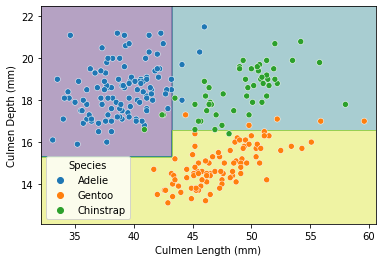

In [11]:
tree.set_params(max_depth=2)
plot_decision_function(X_train, y_train, tree)

As expected, the decision tree made 2 new partitions using the "Culmen
Depth". Now, our tree is more powerful with similar performance to our linear
model.

In [12]:
print(
    f"Accuracy of the {tree.__class__.__name__}: "
    f"{tree.fit(X_train, y_train).score(X_test, y_test):.2f}"
)

Accuracy of the DecisionTreeClassifier: 0.93


At this stage, we have the intuition that a decision tree is built by
successively partitioning the feature space, considering one feature at a
time.
Subsequently, we will present the details regarding the partitioning
mechanism.

## Partitioning mechanism

Let's isolate a single feature. We will present the mechanism allowing to
find the optimal partition for these one-dimensional data.

In [13]:
single_feature = X_train["Culmen Length (mm)"]

Let's check once more the distribution of this feature.

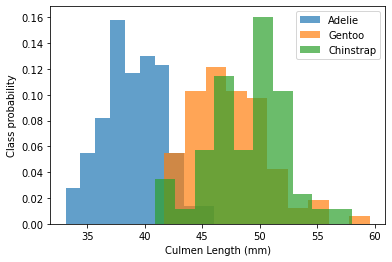

In [14]:
for klass in y_train.unique():
    mask_penguin_species = y_train == klass
    plt.hist(
        single_feature[mask_penguin_species], alpha=0.7,
        label=f'{klass}', density=True
    )
plt.legend()
plt.xlabel(single_feature.name)
_ = plt.ylabel('Class probability')

Seeing this graph, we can easily separate the Adelie specie from
the other species. Alternatively, we can have a scatter plot of all
samples.

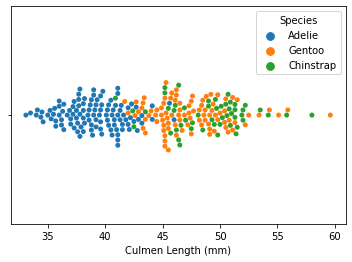

In [15]:
df = pd.concat(
    [single_feature, y_train,
     pd.Series([""] * y_train.size, index=single_feature.index, name="")],
    axis=1,
)
_ = sns.swarmplot(x=single_feature.name, y="", hue=y_train.name, data=df)

Finding a split comes to define a threshold value which will be used to
separate the different classes. To give an example, we will pick a random
threshold value and we will qualify the quality of the split.

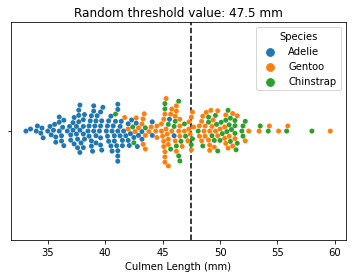

In [16]:
rng = np.random.RandomState(0)
random_indice = rng.choice(single_feature.index)
threshold_value = single_feature.loc[random_indice]

_, ax = plt.subplots()
_ = sns.swarmplot(
    x=single_feature.name, y="", hue=y_train.name, data=df, ax=ax
)
ax.axvline(threshold_value, linestyle="--", color="black")
_ = ax.set_title(f"Random threshold value: {threshold_value} mm")

A random split does not ensure that we pick up a threshold value which
best separate the species. Thus, an intuition will be to find a
threshold value that best divide the Adelie class from other classes. A
threshold around 42 mm would be ideal. Once this split is defined, we could
specify that the sample < 42 mm would belong to the class Adelie and the
samples > 42 mm would belong to the class the most probable (the most
represented in the partition) between the Gentoo and the Chinstrap. In this
case, it seems to be the Gentoo specie, which is in-line with what we
observed earlier when fitting a `DecisionTreeClassifier` with a
`max_depth=1`.

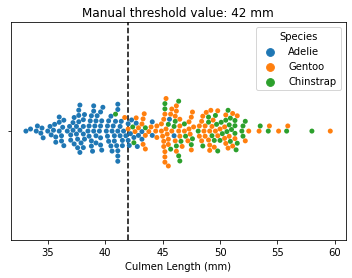

In [17]:
threshold_value = 42

_, ax = plt.subplots()
_ = sns.swarmplot(
    x=single_feature.name, y="", hue=y_train.name, data=df, ax=ax
)
ax.axvline(threshold_value, linestyle="--", color="black")
_ = ax.set_title(f"Manual threshold value: {threshold_value} mm")

Intuitively, we expect the best possible threshold to be around this value
(42 mm) because it is the split leading to the least amount of error. Thus,
if we want to automatically find such a threshold, we would need a way to
evaluate the goodness (or pureness) of a given threshold.

### The split purity criterion

To evaluate the effectiveness of a split, we will use a criterion to qualify
the class purity on the different partitions.

First, let's define a threshold at 42 mm. Then, we will divide the data into
2 sub-groups: a group for samples < 42 mm and a group for samples >= 42 mm.
Then, we will store the class label for these samples.

In [18]:
threshold_value = 42
mask_below_threshold = single_feature < threshold_value
labels_below_threshold = y_train[mask_below_threshold]
labels_above_threshold = y_train[~mask_below_threshold]

We can check the proportion of samples of each class in both partitions. This
proportion is the probability of each class when considering
the partition.

In [19]:
labels_below_threshold.value_counts(normalize=True).sort_index()

Adelie       0.98
Chinstrap    0.01
Gentoo       0.01
Name: Species, dtype: float64

In [20]:
labels_above_threshold.value_counts(normalize=True).sort_index()

Adelie       0.096154
Chinstrap    0.320513
Gentoo       0.583333
Name: Species, dtype: float64

As we visually assess, the partition defined by < 42 mm has mainly Adelie
penguin and only 2 samples which we could considered misclassified. However,
on the partition >= 42 mm, we cannot differentiate Gentoo and Chinstrap
(while they are almost twice more Gentoo).

We should come with a statistical measure which combine the class
probabilities together that can be used as a criterion to qualify the purity
of a partition. We will choose as an example the entropy criterion (also used
in scikit-learn) which is one of the possible classification criterion.

The entropy is defined as: $H(X) = - \sum_{k=1}^{K} p(X_k) \log p(X_k)$

For a binary problem, the entropy function for one of the class can be
depicted as follows:

![title](https://upload.wikimedia.org/wikipedia/commons/2/22/Binary_entropy_plot.svg)

Therefore, the entropy will be maximum when the proportion of sample from
each class will be equal and minimum when only samples for a single class
is present.

Therefore, one searches to minimize the entropy in each partition.

In [21]:
def classification_criterion(labels):
    from scipy.stats import entropy
    return entropy(
        labels.value_counts(normalize=True).sort_index()
    )


entropy_below_threshold = classification_criterion(labels_below_threshold)
entropy_above_threshold = classification_criterion(labels_above_threshold)

print(f"Entropy for partition below the threshold: \n"
      f"{entropy_below_threshold:.3f}")
print(f"Entropy for partition above the threshold: \n"
      f"{entropy_above_threshold:.3f}")

Entropy for partition below the threshold: 
0.112
Entropy for partition above the threshold: 
0.904


In our case, we can see that the entropy in the partition < 42 mm is close to
0 meaning that this partition is "pure" and contain a single class while
the partition >= 42 mm is much higher due to the fact that 2 of the classes
are still mixed.

Now, we are able to assess the quality of each partition. However, the
ultimate goal is to evaluate the quality of the split and thus combine both
measures of entropy to obtain a single statistic.

### Information gain

This statistic is known as the information gain. It combines the entropy of
the different partitions to give us a single statistic qualifying the quality
of a split. The information gain is defined as the difference of the entropy
before making a split and the sum of the entropies of each partition,
normalized by the frequencies of class samples on each partition. The goal is
to maximize the information gain.

We will define a function to compute the information gain given the different
partitions.

In [22]:
def information_gain(labels_below_threshold, labels_above_threshold):
    # compute the entropies in the different partitions
    entropy_below_threshold = classification_criterion(labels_below_threshold)
    entropy_above_threshold = classification_criterion(labels_above_threshold)
    entropy_parent = classification_criterion(
        pd.concat([labels_below_threshold, labels_above_threshold])
    )

    # compute the normalized entropies
    n_samples_below_threshold = labels_below_threshold.size
    n_samples_above_threshold = labels_above_threshold.size
    n_samples_parent = n_samples_below_threshold + n_samples_above_threshold

    normalized_entropy_below_threshold = (
        (n_samples_below_threshold / n_samples_parent) *
        entropy_below_threshold
    )
    normalized_entropy_above_threshold = (
        (n_samples_above_threshold / n_samples_parent) *
        entropy_above_threshold
    )

    # compute the information gain
    return (entropy_parent -
            normalized_entropy_below_threshold -
            normalized_entropy_above_threshold)


print(
    f"The information gain for the split with a threshold at 42 mm is "
    f"{information_gain(labels_below_threshold, labels_above_threshold):.3f}"
)

The information gain for the split with a threshold at 42 mm is 0.455


Now, we are able to quantify any split. Thus, we can evaluate every possible
split and compute the information gain for each split.

In [23]:
splits_information_gain = []
possible_thresholds = np.sort(single_feature.unique())[1:-1]
for threshold_value in possible_thresholds:
    mask_below_threshold = single_feature < threshold_value
    labels_below_threshold = y_train.loc[mask_below_threshold]
    labels_above_threshold = y_train.loc[~mask_below_threshold]
    splits_information_gain.append(
        information_gain(labels_below_threshold, labels_above_threshold)
    )

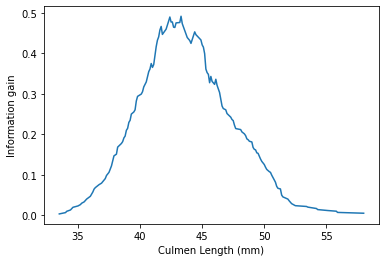

In [24]:
plt.plot(possible_thresholds, splits_information_gain)
plt.xlabel(single_feature.name)
_ = plt.ylabel("Information gain")

As previously mentioned, we would like to find the threshold value maximizing
the information gain.

Text(0.5, 1.0, 'Best threshold: 43.3 mm')

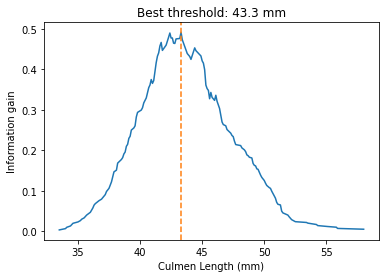

In [25]:
best_threshold_indice = np.argmax(splits_information_gain)
best_threshold_value = possible_thresholds[best_threshold_indice]

_, ax = plt.subplots()
ax.plot(possible_thresholds, splits_information_gain)
ax.set_xlabel(single_feature.name)
ax.set_ylabel("Information gain")
ax.axvline(best_threshold_value, color="tab:orange", linestyle="--")
ax.set_title(f"Best threshold: {best_threshold_value} mm")

By making this brute-force search, we find that the threshold maximizing the
information gain is 43.3 mm.

Let's check if this results is similar than the one found with the
`DecisionTreeClassifier` from scikit-learn.

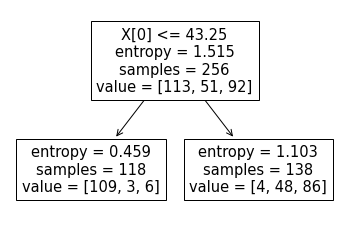

In [26]:
from sklearn.tree import plot_tree

tree = DecisionTreeClassifier(criterion="entropy", max_depth=1)
tree.fit(single_feature.to_frame(), y_train)
_ = plot_tree(tree)

The implementation in scikit-learn gives similar results: 43.25 mm. The
slight difference are only due to some low-level implementation details.

As we previously explained, the split mechanism will be repeated several
times (until we don't have any classification error on the training set). In
the above example, it corresponds to increasing the `max_depth` parameter.

## How prediction works?

We showed the way a decision tree is constructed. However, we did not explain
how and what will be predicted from the decision tree.

First, let's recall the tree structure that we fitted earlier.

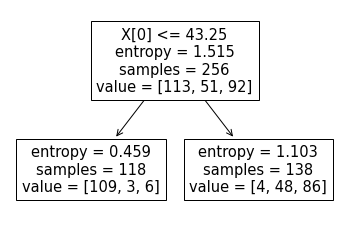

In [27]:
_ = plot_tree(tree)

We recall that the threshold found is 43.25 mm. Thus, let's see the class
prediction for a sample with a feature value below the threshold and another
above the
threshold.

In [28]:
print(f"The class predicted for a value below the threshold is: "
      f"{tree.predict([[35]])}")
print(f"The class predicted for a value above the threshold is: "
      f"{tree.predict([[45]])}")

The class predicted for a value below the threshold is: ['Adelie']
The class predicted for a value above the threshold is: ['Gentoo']


We predict an Adelie penguin for a value below the threshold which is not
surprising since this partition was almost pure. In the other case we
predicted the Gentoo penguin. Indeed, we predict the class the
most probable.

## What about decision tree for regression?

We explained the construction of the decision tree in a classification
problem. The entropy criterion to split the nodes used the class
probabilities. Thus, this criterion is not adapted when the target `y` is
continuous. In this case, we will need specific criterion adapted to
regression problems.

Before going into details with regression criterion, let's observe and
build some intuitions on the characteristics of decision tree used
in regression.

### Decision tree: a non-parametric model

We use the same penguins dataset. However, this time we will formulate a
regression problem instead of a classification problem. Thus, we will try to
infer the body mass of a penguin given its flipper length.

In [29]:
data = pd.read_csv("../datasets/penguins.csv")

data_columns = ["Flipper Length (mm)"]
target_column = "Body Mass (g)"

data = data[data_columns + [target_column]]
data = data.dropna()

X, y = data[data_columns], data[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0,
)

<AxesSubplot:xlabel='Flipper Length (mm)', ylabel='Body Mass (g)'>

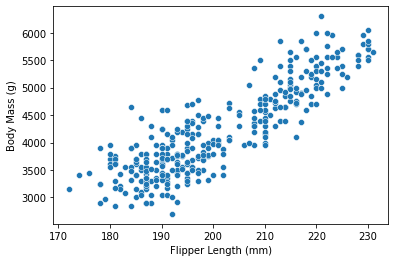

In [30]:
sns.scatterplot(data=data, x="Flipper Length (mm)", y="Body Mass (g)")

Here, we deal with a regression problem because our target is a continuous
variable ranging from 2.7 kg to 6.3 kg. From the scatter plot above, we can
observe that we have a linear relationship between the flipper length
and the body mass. Longer is the flipper of a penguin, heavier will be the
penguin.

For this problem, we would expect the simpler linear model to be able to
model this relationship.

In [31]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

We will first create a function in charge of plotting the dataset and
all possible predictions. This function is equivalent to the earlier
function used for classification.

In [32]:
def plot_regression_model(X, y, model, extrapolate=False, ax=None):
    """Plot the dataset and the prediction of a learnt regression model."""
    # train our model
    model.fit(X, y)

    # make a scatter plot of the input data and target
    training_data = pd.concat([X, y], axis=1)
    if ax is None:
        _, ax = plt.subplots()
    sns.scatterplot(
        data=training_data, x="Flipper Length (mm)", y="Body Mass (g)",
        ax=ax, color="black", alpha=0.5,
    )

    # only necessary if we want to see the extrapolation of our model
    offset = 20 if extrapolate else 0

    # generate a testing set spanning between min and max of the training set
    X_test = np.linspace(
        X.min() - offset, X.max() + offset, num=100
    ).reshape(-1, 1)

    # predict for this testing set and plot the response
    y_pred = model.predict(X_test)
    ax.plot(
        X_test, y_pred,
        label=f"{model.__class__.__name__} trained", linewidth=3,
    )
    plt.legend()
    # return the axes in case we want to add something to it
    return ax

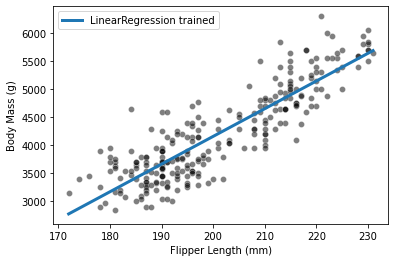

In [33]:
_ = plot_regression_model(X_train, y_train, linear_model)

On the plot above, we see that a non-regularized `LinearRegression` is able
to fit the data. The specificity of the model is that any new predictions
will occur on the line.

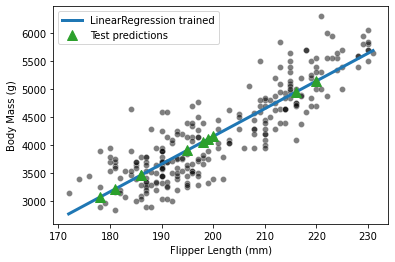

In [34]:
X_test_subset = X_test[:10]
ax = plot_regression_model(X_train, y_train, linear_model)
y_pred = linear_model.predict(X_test_subset)
ax.plot(
    X_test_subset, y_pred, label="Test predictions",
    color="tab:green", marker="^", markersize=10, linestyle="",
)

plt.legend()

On the contrary of linear model, decision trees are non-parametric
models, so they do not rely on the way data should be distributed. In this
regard, it will affect the prediction scheme. Repeating the
above experiment will highlights the differences.

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

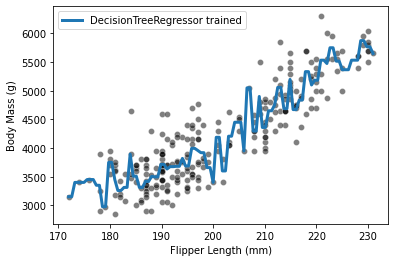

In [36]:
_ = plot_regression_model(X_train, y_train, tree)

We see that the decision tree model does not have a priori and do not end-up
with a straight line to regress flipper length and body mass. The prediction
of a new sample, which was already present in the training set, will give the
same target than this training sample. However, having different body masses
for a same flipper length, the tree will be predicting the mean of the
targets.

So in classification setting, we saw that the predicted value was the most
probable value in the node of the tree. In the case of regression, the
predicted value corresponds to the mean of the target in the node.

This lead us to question whether or not our decision trees are able to
extrapolate to unseen data. We can highlight that this is possible with the
linear model because it is a parametric model.

<AxesSubplot:xlabel='Flipper Length (mm)', ylabel='Body Mass (g)'>

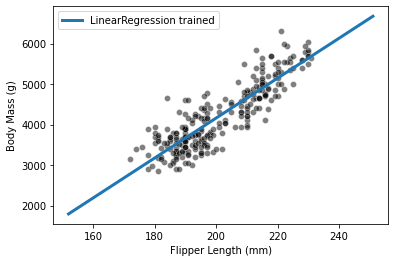

In [37]:
plot_regression_model(X_train, y_train, linear_model, extrapolate=True)

The linear model will extrapolate using the fitted model for flipper length
< 175 mm and > 235 mm. Let's see the difference with the trees.

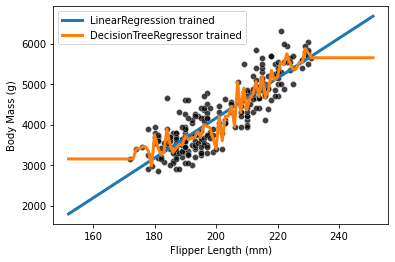

In [38]:
ax = plot_regression_model(X_train, y_train, linear_model, extrapolate=True)
_ = plot_regression_model(X_train, y_train, tree, extrapolate=True, ax=ax)

For the tree, we see that it cannot extrapolate below and above the minimum
and maximum, respectively, of the flipper length encountered during the
training. Indeed, we are predicting the minimum and maximum values of the
training set.

### The regression criterion

In the previous section, we explained the differences between using decision
tree in classification or in regression: the predicted value will be the
most probable class for the classification case while the it will be the mean
in the case of the regression. The second difference that we already
mentioned is the criterion. The classification criterion cannot be applied
in regression setting and we need to use a specific set of criterion.

One of the criterion that can be used in regression is the mean squared
error. In this case, we will compute this criterion in each partition
as in the case of the entropy and select the split leading to the best
improvement (i.e. information gain).

## Importance of decision tree hyper-parameters on generalization

This last section will illustrate the importance of some key hyper-parameters
of the decision tree. We will both illustrate it on classification and
regression datasets that we previously used.

### Creation of the classification and regression dataset

We will first regenerate the classification and regression dataset.

In [39]:
data = pd.read_csv("../datasets/penguins.csv")

In [40]:
data_clf_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_clf_column = "Species"

data_clf = data[
    data_clf_columns + [target_clf_column]
]
data_clf[target_clf_column] = data_clf[
    target_clf_column].str.split().str[0]
data_clf = data_clf.dropna()

X_clf, y_clf = data_clf[data_clf_columns], data_clf[target_clf_column]
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, stratify=y_clf, random_state=0,
)

/opt/hostedtoolcache/Python/3.7.9/x64/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
data_reg_columns = ["Flipper Length (mm)"]
target_reg_column = "Body Mass (g)"

data_reg = data[data_reg_columns + [target_reg_column]]
data_reg = data_reg.dropna()

X_reg, y_reg = data_reg[data_reg_columns], data_reg[target_reg_column]
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, random_state=0,
)

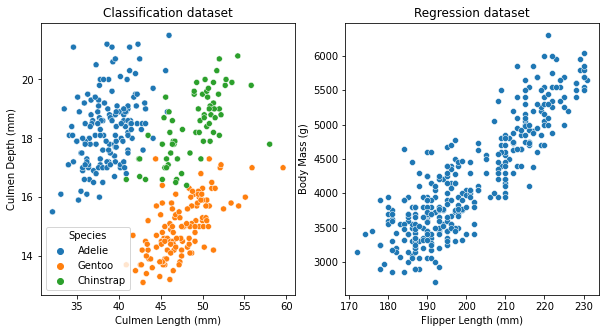

In [42]:
_, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(
    data=data_clf,
    x="Culmen Length (mm)", y="Culmen Depth (mm)", hue="Species",
    ax=axs[0],
)
axs[0].set_title("Classification dataset")
sns.scatterplot(
    data=data_reg, x="Flipper Length (mm)", y="Body Mass (g)",
    ax=axs[1],
)
_ = axs[1].set_title("Regression dataset")

### Effect of the `max_depth` parameter

In decision tree, the most important parameter to get a trade-off between
under-fitting and over-fitting is the `max_depth` parameter. Let's build
a shallow tree (for both classification and regression) and a deeper tree.

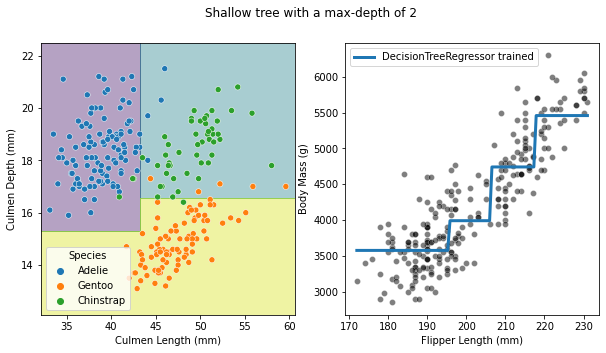

In [43]:
max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plot_decision_function(X_train_clf, y_train_clf, tree_clf, ax=axs[0])
plot_regression_model(X_train_reg, y_train_reg, tree_reg, ax=axs[1])
_ = fig.suptitle(f"Shallow tree with a max-depth of {max_depth}")

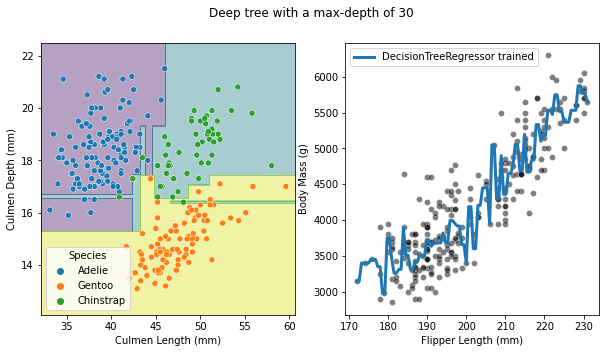

In [44]:
max_depth = 30
tree_clf.set_params(max_depth=max_depth)
tree_reg.set_params(max_depth=max_depth)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plot_decision_function(X_train_clf, y_train_clf, tree_clf, ax=axs[0])
plot_regression_model(X_train_reg, y_train_reg, tree_reg, ax=axs[1])
_ = fig.suptitle(f"Deep tree with a max-depth of {max_depth}")

In both classification and regression setting, we can observe that increasing
the depth will make the tree model more expressive. However, a tree which is
too deep will overfit the training data, creating partitions which will only
be correct for "outliers". The `max_depth` is one of the parameter that one
would like to optimize via cross-validation and a grid-search.

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": np.arange(2, 10, 1)}
tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid)
tree_reg = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid)

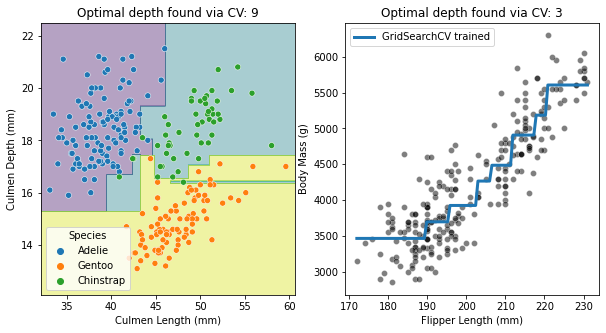

In [46]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plot_decision_function(X_train_clf, y_train_clf, tree_clf, ax=axs[0])
axs[0].set_title(
    f"Optimal depth found via CV: {tree_clf.best_params_['max_depth']}"
)
plot_regression_model(X_train_reg, y_train_reg, tree_reg, ax=axs[1])
_ = axs[1].set_title(
    f"Optimal depth found via CV: {tree_reg.best_params_['max_depth']}"
)

The other parameters are used to fine tune the decision tree and have less
impact than `max_depth`.